# Learning representations learning with Autoencoders : using constraints on the hidden representations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import sigmoid, conv2d, relu, dropout, max_pool2d
from torchvision import datasets, transforms
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Interesting link on optimization routines : [here](https://github.com/bentrevett/a-tour-of-pytorch-optimizers/blob/main/a-tour-of-pytorch-optimizers.ipynb)

## Loading MNIST

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [3]:
# to be modified if not on colab
root_dir = './data/MNIST/'
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=True, download=True, transform=transforms.ToTensor()),
    batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

## Useful Functions

To plot for a few samples, the raw data, the recontructed data, and the hidden representation

In [4]:
def to_img(x):
    x = x.cpu().data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, 28, 28])
    return x

def plot_reconstructions(model, x=-1, y=4):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    The encoder is called by model.encoder
    The decoder is called by model.decoder
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    data = data.view([-1, 784])
    data.requires_grad = False
    data = data.to(device)
    true_imgs = data
    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)

    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[i].reshape(x,y))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

## Simple Auto-Encoder with MSE loss

We start with the simplest autoencoder: a single, fully-connected layer as the encoder and decoder, trained with MSE loss.

* Define a simple Autoencoder with one hidden layer
* Train it on mnist: Use MSE Loss and Adam optimizer (See the documentation for [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).)
* Plot input data, reconstruted data and hidden representations

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = relu(x)
        return x

In [9]:
input_dim = 784
encoding_dim = 32

model = AutoEncoder(input_dim, encoding_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model

AutoEncoder(
  (encoder): Linear(in_features=784, out_features=32, bias=True)
  (decoder): Linear(in_features=32, out_features=784, bias=True)
)

In [10]:
def train_model(
        model,
        criterion,
        train_loader,
        epochs,
        optimizer
):
    running_losses = []
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view([-1, 784]).to(device)
            optimizer.zero_grad()
            pred = model(data)
            loss = criterion(pred, data)
            loss.backward()
            optimizer.step()

            running_losses.append(loss)

        print(f'Train Epoch: {epoch}\tLoss: {loss.data.item()}')
        if epoch %10 == 0:
            plot_reconstructions(model)
    plot_reconstructions(model)


Train Epoch: 0	Loss: 0.02410849556326866


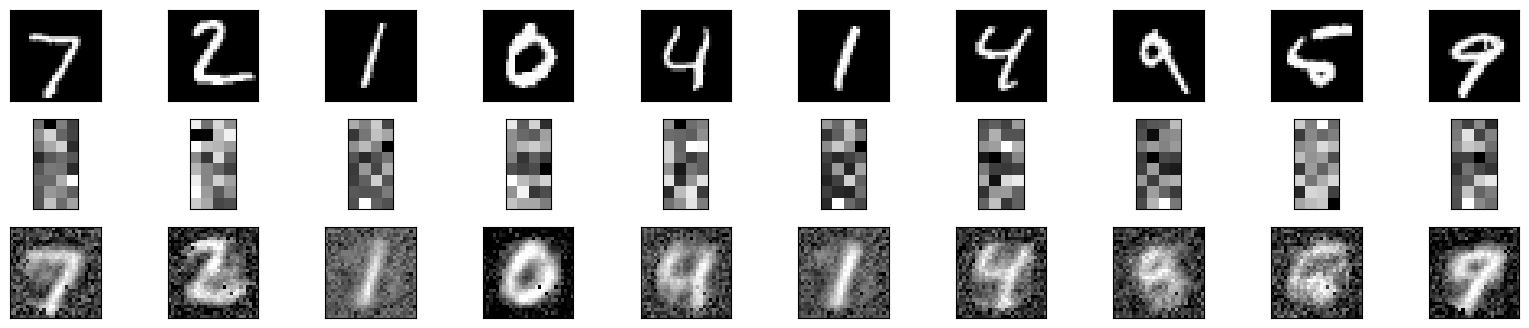

Train Epoch: 1	Loss: 0.01684591732919216
Train Epoch: 2	Loss: 0.014992976561188698
Train Epoch: 3	Loss: 0.014444603584706783
Train Epoch: 4	Loss: 0.012523476034402847
Train Epoch: 5	Loss: 0.012489872984588146
Train Epoch: 6	Loss: 0.011362798511981964
Train Epoch: 7	Loss: 0.013593252748250961
Train Epoch: 8	Loss: 0.011157908476889133
Train Epoch: 9	Loss: 0.011776437051594257


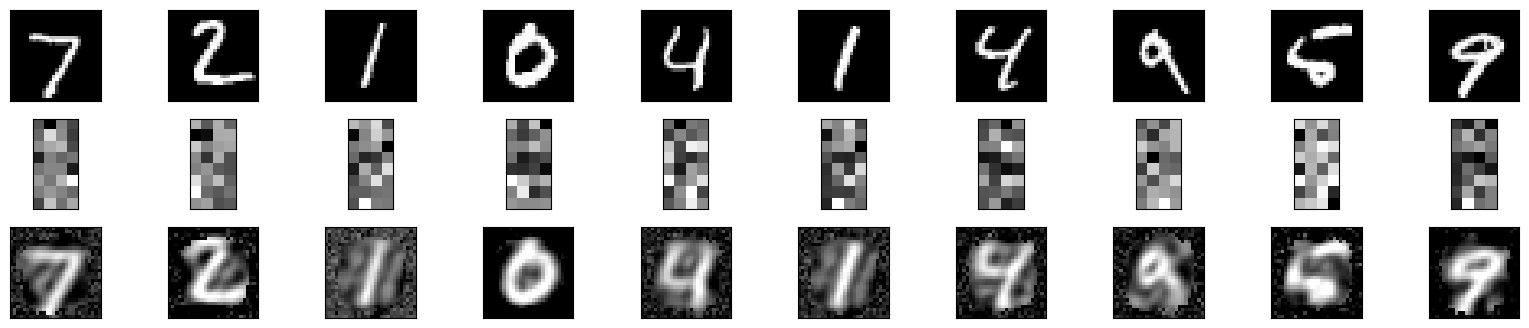

In [11]:
train_model(
    model=model,
    criterion=criterion,
    train_loader=train_loader,
    epochs=10,
    optimizer=optimizer
)

## Using a constraint on the norm of the hidden representations

We modify the learnig of the above AE by adding a term to the objective function: the L1 norm (use *torch.norm(vector,1)*) of the hidden representations. Wde will use $C(W) = MSE(W)+ \lambda \sum_i |h_i|$ where $\lambda$ should be set by hand (cross validation) and $|h_i|$ stands for the L1 norm of the hidden representation of sample $x_i$.

Train the lodel with MSE Loss and Adam optimizer.


In [12]:
class SparseAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(SparseAutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        h = self.encoder(x)
        x = self.decoder(h)
        x = relu(x)
        return x, h


input_dim = 784
encoding_dim = 32

model = SparseAutoEncoder(input_dim, encoding_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model

SparseAutoEncoder(
  (encoder): Linear(in_features=784, out_features=32, bias=True)
  (decoder): Linear(in_features=32, out_features=784, bias=True)
)

In [13]:
def train_model_sparse(
    model,
    criterion,
    train_loader,
    lambda_value,
    epochs,
    optimizer):

    model.train()

    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view([-1, 784]).to(device)
            optimizer.zero_grad()
            pred, h = model(data)
            loss = criterion(pred, data)


            loss = loss + lambda_value * torch.sum(torch.norm(h))

            loss.backward()
            optimizer.step()


        print('Train Epoch: {}\tLoss: {:.6f}\t'.format(epoch, loss.data.item()))
        if epoch %10 == 0:
          plot_reconstructions(model)
    plot_reconstructions(model)

Train Epoch: 0	Loss: 0.027060	


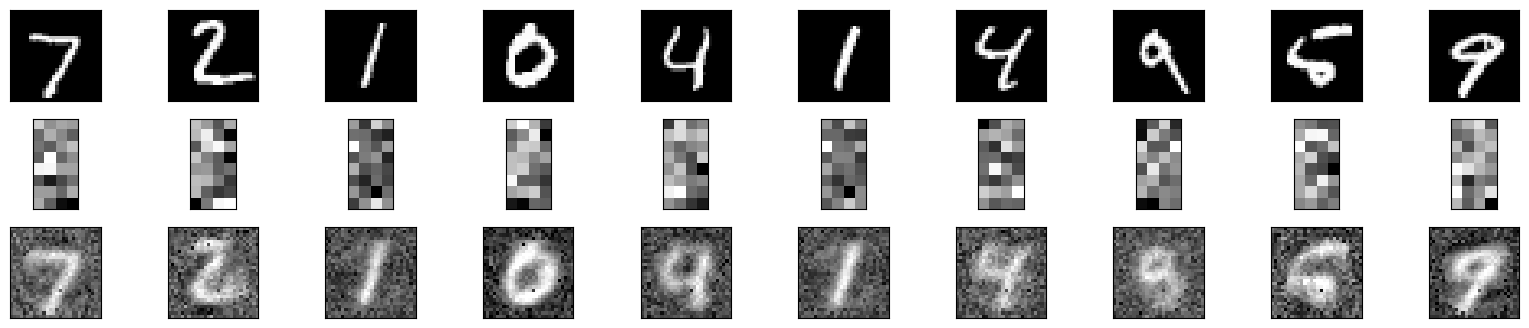

Train Epoch: 1	Loss: 0.019828	
Train Epoch: 2	Loss: 0.016004	
Train Epoch: 3	Loss: 0.015196	
Train Epoch: 4	Loss: 0.014393	
Train Epoch: 5	Loss: 0.014580	
Train Epoch: 6	Loss: 0.014663	
Train Epoch: 7	Loss: 0.013411	
Train Epoch: 8	Loss: 0.013659	
Train Epoch: 9	Loss: 0.013664	


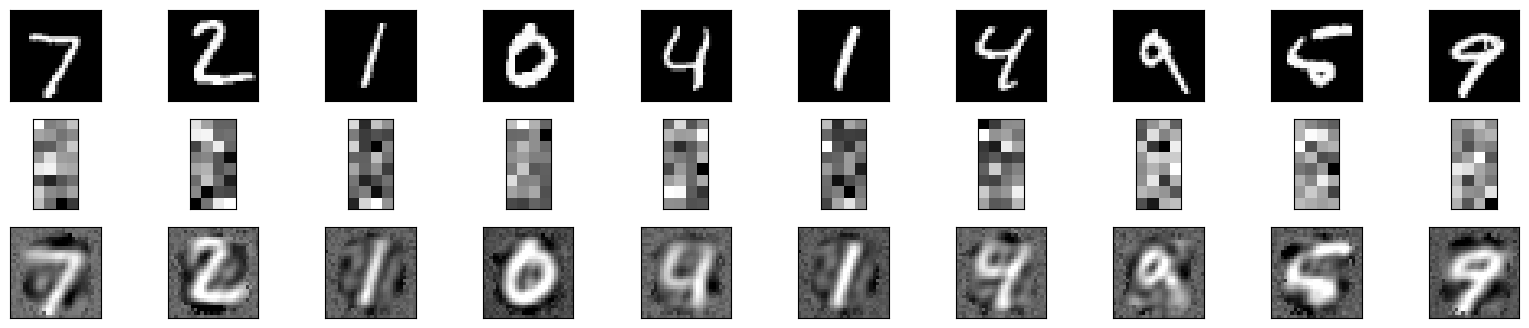

In [14]:
train_model_sparse(
    model=model,
    criterion=criterion,
    lambda_value=1e-4,
    train_loader=train_loader,
    epochs=10,
    optimizer=optimizer
)

## Deeper Autoencoder

Now you will code an autoencoder where both the encoder and the decoder are multilayer perceptron (MLP). You can take for the encoder a first hidden layer with dimension 128, a second one with dimension 64 and then the code of dimension 32. These numbers should be parameters of the construction method. For the decoder, take the same sequence of dimensions in reverse order.

Create a DeepEncoder class then a DeepDecoder class and finally a DeepAutoEncoder class. Use *nn.ModuleList()* (see the doc [here](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html))

Train the model with MSE Loss and Adam optimizer.


In [6]:
class DeepEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, hidden_dims):
        super(DeepEncoder, self).__init__()
        self.encoder = nn.ModuleList()
        current_dim = input_dim
        for hdim in hidden_dims:
            self.encoder.append(nn.Linear(current_dim, hdim))
            current_dim = hdim
        self.encoder.append(nn.Linear(current_dim, encoding_dim))

    def forward(self, x):
        for layer in self.encoder[:-1]:
            x = F.relu(layer(x))
        x = self.encoder[-1](x)
        return x


In [7]:
class DeepDecoder(nn.Module):
    def __init__(self, encoding_dim, output_dim, hidden_dims):
        super(DeepDecoder, self).__init__()
        self.decoder = nn.ModuleList()
        current_dim = encoding_dim
        for hdim in reversed(hidden_dims):
            self.decoder.append(nn.Linear(current_dim, hdim))
            current_dim = hdim
        self.decoder.append(nn.Linear(current_dim, output_dim))

    def forward(self, x):
        for layer in self.decoder[:-1]:
            x = F.relu(layer(x))
        x = self.decoder[-1](x)
        return x

In [8]:
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, hidden_dims):
        super(DeepAutoEncoder, self).__init__()
        self.encoder = DeepEncoder(input_dim, encoding_dim, hidden_dims).to(device)
        self.decoder = DeepDecoder(encoding_dim, input_dim, hidden_dims).to(device)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

In [9]:
input_dim = 784
encoding_dim = 32
hidden_dims = [128, 64]
model = DeepAutoEncoder(input_dim, encoding_dim, hidden_dims).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [10]:
def train_model_sparse(
        model,
        criterion,
        train_loader,
        lambda_value,
        epochs,
        optimizer
):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view([-1, input_dim]).to(device)
            optimizer.zero_grad()

            pred, h = model(data)
            loss = criterion(pred, data)


            sparsity_loss = lambda_value * torch.sum(torch.norm(h, p=1))
            loss += sparsity_loss

            loss.backward()
            optimizer.step()

        print(f'Train Epoch: {epoch+1}/{epochs}\tLoss: {loss.item():.6f}')
        if epoch %10 == 0:
          plot_reconstructions(model)
    plot_reconstructions(model)


Train Epoch: 1/10	Loss: 0.062069


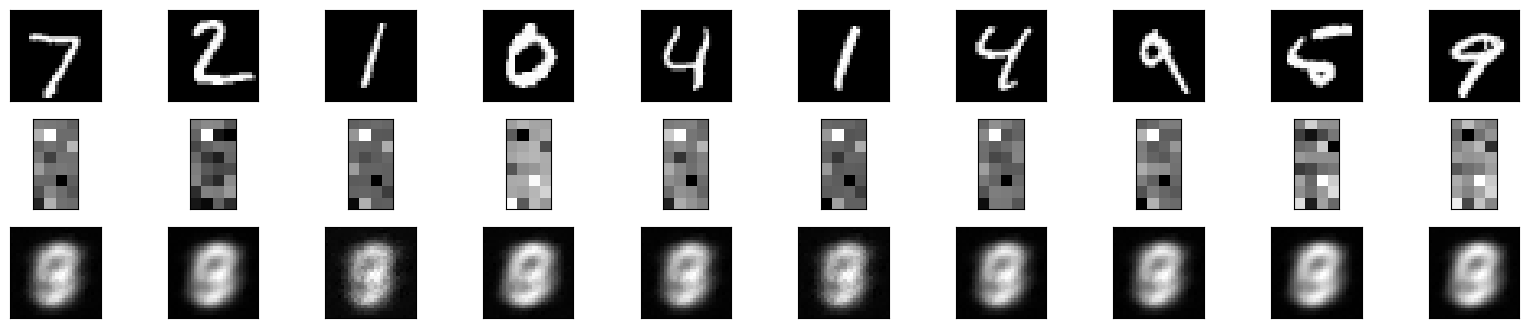

Train Epoch: 2/10	Loss: 0.061330
Train Epoch: 3/10	Loss: 0.062644
Train Epoch: 4/10	Loss: 0.062714
Train Epoch: 5/10	Loss: 0.058807
Train Epoch: 6/10	Loss: 0.052248
Train Epoch: 7/10	Loss: 0.052308
Train Epoch: 8/10	Loss: 0.054134
Train Epoch: 9/10	Loss: 0.052584
Train Epoch: 10/10	Loss: 0.050498


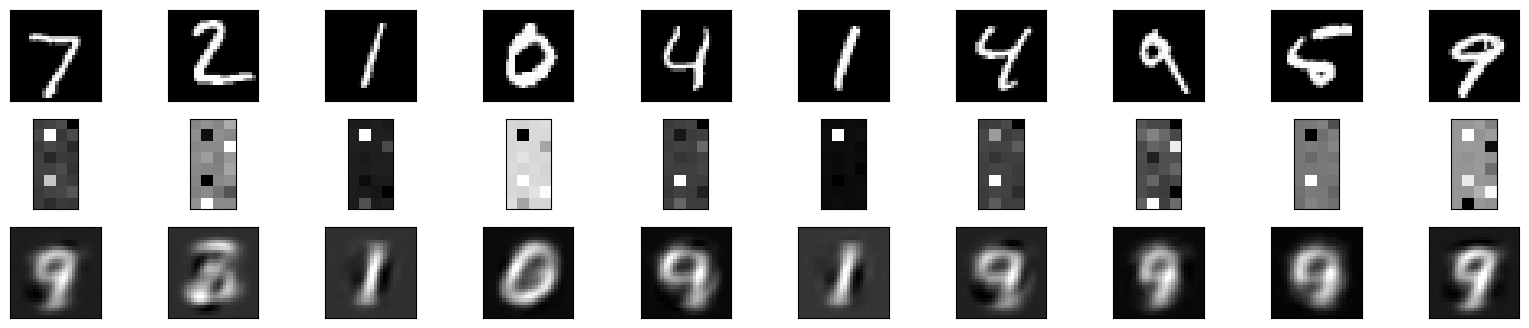

In [11]:
train_model_sparse(
    model=model,
    criterion=criterion,
    lambda_value=1e-4,
    train_loader=train_loader,
    epochs=10,
    optimizer=optimizer
)

## Relearn the DeepAutoEncoder using a `BCE Loss` for each pixel instead of the `MSELoss`.

Train Epoch: 1/10	Loss: 0.265563


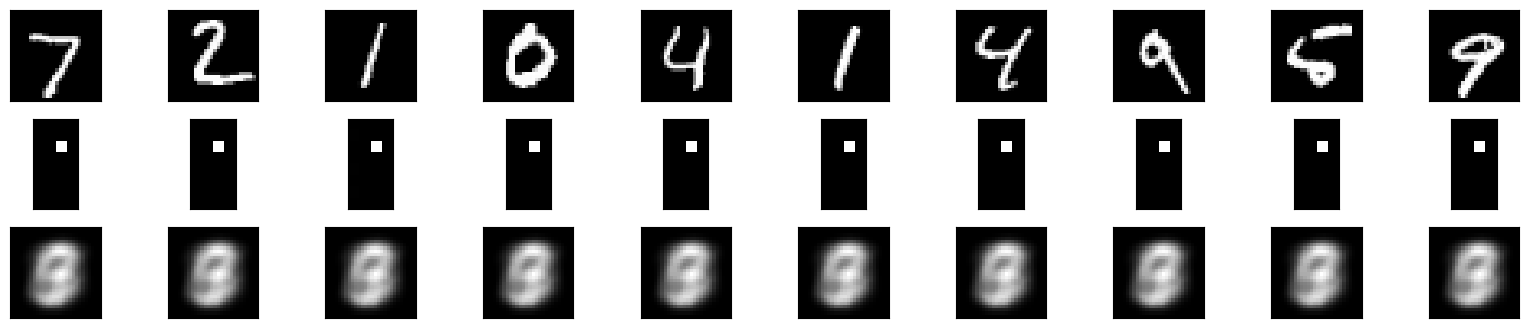

Train Epoch: 2/10	Loss: 0.268294
Train Epoch: 3/10	Loss: 0.275248
Train Epoch: 4/10	Loss: 0.257937
Train Epoch: 5/10	Loss: 0.240537
Train Epoch: 6/10	Loss: 0.250923
Train Epoch: 7/10	Loss: 0.241507
Train Epoch: 8/10	Loss: 0.228159
Train Epoch: 9/10	Loss: 0.234005
Train Epoch: 10/10	Loss: 0.222266


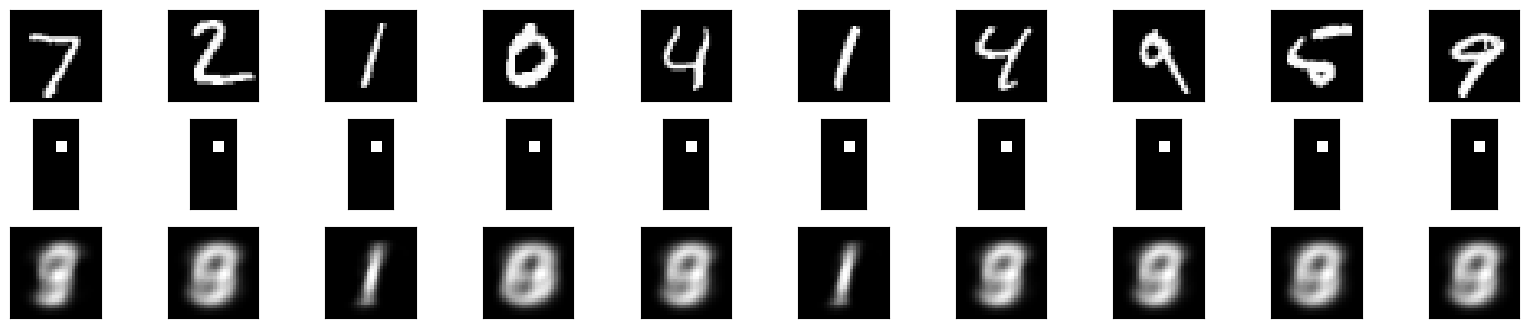

In [5]:
class DeepEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, hidden_dims):
        super(DeepEncoder, self).__init__()
        self.encoder = nn.ModuleList()
        current_dim = input_dim
        for hdim in hidden_dims:
            self.encoder.append(nn.Linear(current_dim, hdim))
            current_dim = hdim
        self.encoder.append(nn.Linear(current_dim, encoding_dim))

    def forward(self, x):
        for layer in self.encoder[:-1]:
            x = F.relu(layer(x))
        x = self.encoder[-1](x)
        return torch.sigmoid(x)


class DeepDecoder(nn.Module):
    def __init__(self, encoding_dim, output_dim, hidden_dims):
        super(DeepDecoder, self).__init__()
        self.decoder = nn.ModuleList()
        current_dim = encoding_dim
        for hdim in reversed(hidden_dims):
            self.decoder.append(nn.Linear(current_dim, hdim))
            current_dim = hdim
        self.decoder.append(nn.Linear(current_dim, output_dim))

    def forward(self, x):
        for layer in self.decoder[:-1]:
            x = F.relu(layer(x))
        x = self.decoder[-1](x)
        return torch.sigmoid(x)


class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, hidden_dims):
        super(DeepAutoEncoder, self).__init__()
        self.encoder = DeepEncoder(input_dim, encoding_dim, hidden_dims).to(device)
        self.decoder = DeepDecoder(encoding_dim, input_dim, hidden_dims).to(device)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z


input_dim = 784
encoding_dim = 32
hidden_dims = [128, 64]
model = DeepAutoEncoder(input_dim, encoding_dim, hidden_dims).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


def train_model_sparse(
        model,
        criterion,
        train_loader,
        lambda_value,
        epochs,
        optimizer
):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view([-1, input_dim]).to(device)
            optimizer.zero_grad()

            pred, h = model(data)
            loss = criterion(pred, data)

            sparsity_loss = lambda_value * torch.sum(torch.norm(h, p=1))
            loss += sparsity_loss

            loss.backward()
            optimizer.step()

        print(f'Train Epoch: {epoch + 1}/{epochs}\tLoss: {loss.item():.6f}')
        if epoch % 10 == 0:
            plot_reconstructions(model)
    plot_reconstructions(model)


train_model_sparse(
    model=model,
    criterion=criterion,
    lambda_value=1e-4,
    train_loader=train_loader,
    epochs=10,
    optimizer=optimizer
)

## Interpolating in the hidden (latent) space.


1.   Take two sample data $x_1$ and $x_2$
2.   Compute their latent reperesentations $z_1$ and $z_2$
3.   Build N intermediate representations between $z_1$ and $z_2$ by linear interpolation
4. Decode these intermediate $z$
5. Assume all the images are in an array Interpols with Interpols[0] is the decoging of $z_1$ and Interpols[N] is the decoging of $z_2$, plot all these decoded images using the cell below




## Denoising AE


Using previous code and with minimal modifications, you will transform your AE in a denoising AE, i.e. an autoencoder which takes as input a noisy image and that outputs the denoised image.

You first apply some noise to your input. You can add some random noise or erase some of the pixels, or use *random_binary* below.

### *Useful*

In [ ]:
def random_binary(shape,rate): # rate = proba of 0
  A = torch.rand(shape).to(device)
  A[A>rate]=1.0
  A[A<rate]=0.0
  return A


In [ ]:
random_binary((2,2),0.1)

tensor([[1., 1.],
        [1., 1.]], device='cuda:0')

In [ ]:
# Now you need to modify the plot function
def plot_denoising(model, noise=0.1):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, , the second row is the noisy digits,
    the third row is the encoded vector and
    the bottom is the decoder reconstruction.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    #
    # your code here to compute
    # noisy_data


    data = data.view([-1, 784]).to(device)
    noisy_data = data * random_binary (data.size(),noise)

    # encoded_imgs

    encoded_imgs = model.encoder(noisy_data)


    # decoded_imgs
    decoded_imgs = model.decoder(encoded_imgs)

    #
    true_imgs = to_img(data)
    noisy_imgs = to_img(noisy_data)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display corrupted original
        ax = plt.subplot(4, n, i + 1 +n)
        plt.imshow(noisy_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display code
        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, n, i + 1 +  3*n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

### Rewrite the train function

Apply binary noise on the fly to inputs. Use a parameter *noiselevel* for the rate parameter in the random_binary function above.

In [ ]:
# You need first to modify the training process by adding noise to your data
# Hint if you want to erase pixels: https://stackoverflow.com/questions/49216615/is-there-an-efficient-way-to-create-a-random-bit-mask-in-pytorch
def train_denoiser(model,loss_fn,data_loader=None,epochs=1,optimizer=None, noise=0.1):
    model.train()
    for epoch in range(epochs):
      for batch_idx, (data, _) in enumerate(train_loader):
        ...

      print('Train Epoch: {}\tLoss: {:.6f}'.format(
        epoch, loss.data.item()))
      if epoch %10 == 0:
        plot_denoising(model, noise)
    plot_denoising(model, noise)


## Use convolutional AutoEncoders

You may use convolutional autoencoders. Define a convolutional Encoder and a convolutional Decoder using *Conv2d* layers in the encoder and *ConvTranspose2d* layers in the decoder ([see transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)).

Rewrite the plot function and train the model.

In [46]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [41]:
model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [53]:
def train_model_conv(model, criterion, train_loader, num_epochs, optimizer):
    model.train()
    for epoch in range(num_epochs):
        for batch in train_loader:
            imgs, _ = batch
            imgs = imgs.to(device)

            output = model(imgs)
            if isinstance(output, tuple):
                output = output[0]
            loss = criterion(output, imgs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Époch [{epoch+1}/{num_epochs}], Perte: {loss.item():.4f}')

# Entraînement du modèle
train_model_conv(
    model=model,
    criterion=criterion,
    train_loader=train_loader,
    num_epochs=20,
    optimizer=optimizer
)

Époch [1/20], Perte: 0.0473
Époch [2/20], Perte: 0.0314
Époch [3/20], Perte: 0.0237
Époch [4/20], Perte: 0.0202
Époch [5/20], Perte: 0.0174
Époch [6/20], Perte: 0.0171
Époch [7/20], Perte: 0.0159
Époch [8/20], Perte: 0.0136
Époch [9/20], Perte: 0.0114
Époch [10/20], Perte: 0.0124
Époch [11/20], Perte: 0.0115
Époch [12/20], Perte: 0.0107
Époch [13/20], Perte: 0.0098
Époch [14/20], Perte: 0.0101
Époch [15/20], Perte: 0.0105
Époch [16/20], Perte: 0.0094
Époch [17/20], Perte: 0.0107
Époch [18/20], Perte: 0.0095
Époch [19/20], Perte: 0.0097
Époch [20/20], Perte: 0.0101
